## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
from sklearn.metrics import *
warnings.filterwarnings('ignore')

#Importing pytorch functions and modules
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.utils.data 
torch.cuda.empty_cache()

import librosa
from librosa.core import stft,istft

#Setting random seed for reproducibility
SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

GPU MIL GAYA, AB MACHAYENGE!!!
Tesla P100-PCIE-16GB


In [0]:

def get_data_loader(tr_v_te,batch_size,max_len):
  """
  Creates Pytorch dataloader object from the specified folder and batch size
  Additionally, it saves the data along with respective lengths(to be used in RNN)
  Arguments - 
  tr_v_te: which is among{tr,v,te} indicating which folder to load files from
  batch_size: batch_size for creating data loader
  max_len: maximum allowable length of sound signal after stft (will give error of any sound lengths exceeds this) 

  """
  n_signals = int(len(os.listdir(tr_v_te+"/"))/3)
  input_dm = 513
  #maximum length of sound file
  loader_file = tr_v_te + "_loader_" +str(batch_size) + ".pt"
  #if data loader file already exists, read it directly instead of taking in new file
  if(loader_file not in os.listdir()):
      data_files = ["seq_lengths_"+tr_v_te+".pt","X_"+tr_v_te+".npy","M_"+tr_v_te+".npy"]
      if(set(data_files).issubset(set(os.listdir()))):
          seq_lengths = torch.load(data_files[0])
          X = np.load(data_files[1])
          M = np.load(data_files[2])
          print("loaded data files")
      else:
          print("Data files not found, reading sound files...")
          
          nos = np.arange(0,n_signals).astype(np.str)
          S_complex = np.zeros((n_signals,input_dm,max_len)).astype(np.complex64)
          N_complex = np.zeros((n_signals,input_dm,max_len)).astype(np.complex64)
          seq_lengths = np.zeros((n_signals)).astype(np.int)
          for i,no in enumerate(nos):
              s_filename = "/".join([tr_v_te,tr_v_te]) +"s" + no.zfill(4) + ".wav"
              s, sr=librosa.load(s_filename, sr=None)
              s_complex = stft(s, n_fft=1024, hop_length=512)
              seq_lengths[i] = int(s_complex.shape[1])
              S_complex[i,:,0:seq_lengths[i]] = s_complex



              n_filename = "/".join([tr_v_te,tr_v_te]) +"n" + no.zfill(4) + ".wav"
              n,_=librosa.load(n_filename, sr=sr)
              n_complex = stft(n, n_fft=1024, hop_length=512)
              assert(s_complex.shape[1]==n_complex.shape[1])
              N_complex[i,:,0:seq_lengths[i]] = n_complex

          S = np.abs(S_complex)
          del(S_complex)
          N = np.abs(N_complex)
          del(N_complex)
          M = np.greater(S,N).astype(np.float64)
          del(S)
          del(N)

          X_complex = np.zeros((n_signals,input_dm,max_len)).astype(np.complex64)  
          for i,no in enumerate(nos):     
              x_filename = "/".join([tr_v_te,tr_v_te]) +"x" + no.zfill(4) + ".wav"
              x,_=librosa.load(x_filename, sr=sr)
              x_complex = stft(x, n_fft=1024, hop_length=512)
              X_complex[i,:,0:seq_lengths[i]] = x_complex
          X = np.abs(X_complex)
          


          seq_lengths = torch.tensor(seq_lengths).to('cpu')
          M = M.reshape((n_signals,max_len,input_dm))
          X = X.reshape((n_signals,max_len,input_dm))
          torch.save(seq_lengths,data_files[0])
          np.save(data_files[1],X)
          np.save(data_files[2],M)
          print("Sound files read")
          
          
      assert(len(np.unique(X))>2)
      data_ind = np.arange(0,n_signals)
      data_loader_ind = torch.utils.data.DataLoader(dataset=data_ind, 
                                                   batch_size=batch_size, 
                                                   shuffle=True)

      data_loader = []
      for batch in data_loader_ind:
          x_len = seq_lengths[batch]
          sort_ind = torch.flip(torch.argsort(x_len),dims=[0])
          sort_ind = sort_ind.cpu().numpy()
          x_len = x_len[sort_ind]
          
          data_loader.append((torch.tensor(X[batch,:,:][sort_ind]).to(device),x_len,torch.tensor(M[batch,:,:][sort_ind]).to(device)))

      data_loader = torch.utils.data.dataloader.DataLoader(data_loader)
      del(X)
      del(M)
      torch.save(data_loader,loader_file)
      print("created data loader:"+loader_file)
  
  else:
      print("data loader file found")
      data_loader = torch.load(loader_file)
      
  return(data_loader)

#Calculate snr for sound signal
def get_snr(s_actual,s_pred):
    num = np.dot(s_actual,s_actual)
    den = np.dot((s_actual-s_pred),(s_actual-s_pred))
    return(10*np.log10(num/den))

def get_snrs(model,tr_v_te,n_signals):
  """
  Get array of SNRs of sound files from a specified folder and trained model
  Arguments - 
  tr_v_te: which is among{tr,v,te} indicating which folder to load files from
  model: trained pytorch model
  n_signals: Number of signals to find SNR for(ideally this would be all the files in the folder but that often exceeds RAM and takes huge amount of time)


  """
  print("Calulcating SNR for first "+str(n_signals)+" files in "+tr_v_te+"/ folder...")
  nos = np.arange(0,n_signals).astype(np.str)
  signals = []
  S_complex = np.zeros((n_signals,513,max_len)).astype(np.complex64)
  X_complex = np.zeros((n_signals,513,max_len)).astype(np.complex64)
  seq_lengths = np.zeros((n_signals))
  for i,no in enumerate(nos):
      s_filename = "/".join([tr_v_te,tr_v_te]) +"s" + no.zfill(4) + ".wav"
      x_filename = "/".join([tr_v_te,tr_v_te]) +"x" + no.zfill(4) + ".wav"
      s, sr=librosa.load(s_filename, sr=None)
      signals.append(s)
      x, sr=librosa.load(x_filename, sr=None)
      s_complex = stft(s, n_fft=1024, hop_length=512)
      x_complex = stft(x, n_fft=1024, hop_length=512)
      l = int(s_complex.shape[1])
      seq_lengths[i]=l
      S_complex[i,:,0:l] = s_complex
      X_complex[i,:,0:l] = x_complex
      
  S_mag = np.abs(S_complex)
  S_cap = np.nan_to_num(np.divide(S_complex,S_mag))
  X_mag = np.abs(X_complex)
  #X_cap = np.nan_to_num(np.divide(X_complex,X_mag))

  X_inp = torch.tensor(X_mag).reshape(n_signals,max_len,513).to(device)
  X_len = torch.tensor(seq_lengths,dtype=torch.int64)
  sort_ind = torch.flip(torch.argsort(X_len),dims=[0])
  X_len = X_len[sort_ind]
  X_inp = X_inp[sort_ind]

  M_hat = F.sigmoid(model.forward(X_inp,X_len)).gt(0.5).int()



  S_complex = S_complex[sort_ind]
  S_mag = S_mag[sort_ind]
  S_cap = S_cap[sort_ind]
  signals = [signals[i] for i in sort_ind]
  seq_lengths = X_len.numpy()

  S_mag_pred = torch.mul(X_inp,M_hat).reshape(n_signals,513,max_len).detach().cpu().numpy()
  S_complex_pred = np.multiply(S_mag_pred,S_cap)

  SNR_list = np.zeros((n_signals))
  for i in range(0,n_signals):
      s_complex_pred = S_complex_pred[i,:,0:seq_lengths[i]]
      
      s = signals[i]
      s_pred = istft(s_complex_pred, hop_length=512, length = len(s))
      
      SNR_list[i] = get_snr(s,s_pred)
  
  print("SNR mean = " + str(np.mean(SNR_list)))
  print("SNR median = " + str(np.median(SNR_list)))

  return(SNR_list)



    
class denoise_RNN(nn.Module):
    """
    Pytorch model class for removing noise from sound
    """
    def __init__(self, input_dm, n_lstm_layers, n_lstm_units, output_dm,dropout,max_len):
        
        super(denoise_RNN,self).__init__()
        self.n_lstm_units = n_lstm_units
        self.output_dm = output_dm
        self.max_len = max_len
        self.dropout = dropout

        #LSTM
        self.lstm = nn.LSTM(
            input_size=input_dm,
            hidden_size=n_lstm_units,
            num_layers=n_lstm_layers,
            batch_first=True,
            dropout = self.dropout,
            bidirectional=True
        )
        
        # output layer which projects back to tag space
        self.fc = nn.Linear(self.n_lstm_units*self.max_len*2,self.output_dm*self.max_len)
        self.dd = nn.Dropout(self.dropout)


    def forward(self, X, X_lengths):
        
        X_packed = nn.utils.rnn.pack_padded_sequence(X,X_lengths, batch_first=True)
        X_packed, (hidden, cell) = self.lstm(X_packed)
        X,_ = nn.utils.rnn.pad_packed_sequence(X_packed, batch_first=True, 
                                                   padding_value=0.0, total_length=self.max_len)
        X = X.reshape(X.shape[0],-1)
        X = self.fc(X)
        #Instead of taking sigmoid here we use loss function BCE with logits because although both processes
        # are the same, the latter is more stable and does go into errors caused my rounding off of digits.

        X = self.dd(X)
        M_hat = X.reshape(X.shape[0],self.max_len,self.output_dm)
        return M_hat       


class train_lstm:
    """
    Class for training an LSTM model(takes in the above specified lstm model class)
    
    """
    def __init__(self,batch_size,dropout,n_lstm_layers,n_lstm_units,input_dm,output_dm,max_len,saved_model):
        super(train_lstm,self).__init__()
        self.batch_size = batch_size
        self.output_dm = output_dm
        
        self.n_lstm_units = n_lstm_units
        #Load or create pytorch data loader files based n the specified batch_size
        self.train_loader = get_data_loader("tr",batch_size,max_len)
        self.val_loader = get_data_loader("v",batch_size,max_len)
        
        self.n_train = np.sum([len(x.squeeze()) for (x,xl,m) in self.train_loader])
        self.n_val = np.sum([len(x.squeeze()) for (x,xl,m) in self.val_loader])
        
        self.rnn_model = denoise_RNN(input_dm=input_dm, 
                        n_lstm_layers=n_lstm_layers,
                        n_lstm_units=self.n_lstm_units,
                        output_dm=output_dm,
                        dropout=dropout,
                        max_len=max_len).to(device)
    
        self.best_loss = torch.tensor(np.inf)
        if(saved_model!=None):
            self.rnn_model.load_state_dict(torch.load(saved_model))
        
        
    def train(self,max_epochs,verbose,learning_rate,model_op):
        

        optimizer = torch.optim.Adam(self.rnn_model.parameters(), lr=learning_rate)

        criterion = torch.nn.BCELoss(reduction="sum")

        self.train_loss_history = []
        self.val_loss_history = []

        
        epoch = 0
        rounds = 0
        early_stopping_rounds = 5
        stop = False
        

        while ((epoch < max_epochs)&(stop==False)):

            total_loss = 0.0
            for x_input,x_length,m in self.train_loader:
                x_input = x_input.squeeze()
                x_length = x_length.squeeze()
                m = m.squeeze()
     
                m_pred = self.rnn_model.forward(x_input,x_length)

                batch_ce_loss = 0.0

                for i in range(m_pred.size(0)):
                    m_pred_up = m_pred[i,0:x_length[i],:].reshape(1,x_length[i]*self.output_dm)
                    m_up = m[i,0:x_length[i],:].reshape(1,x_length[i]*self.output_dm).float()
                    #print("reshape successfull")
                    ce_loss = F.binary_cross_entropy_with_logits(m_pred_up,m_up,reduction="sum")
                    # ce_loss = criterion(m_pred[i,0:x_length[i],:].view(1,-1), 
                    #                     m[i,0:x_length[i],:].view(1,-1).float())
                    batch_ce_loss += ce_loss

                optimizer.zero_grad()
                batch_ce_loss.backward()
                optimizer.step()
                total_loss = total_loss + batch_ce_loss.item()
            train_loss = total_loss/self.n_train
            self.train_loss_history.append(train_loss.item())

            total_loss = 0.0
            for v_input,v_length,m in self.val_loader:
                v_input = v_input.squeeze()
                v_length = v_length.squeeze()
                m = m.squeeze()
                m_pred = self.rnn_model.forward(v_input,v_length)
                batch_ce_loss = 0.0
                
                for i in range(m_pred.size(0)):
                    
                    m_pred_up = m_pred[i,0:v_length[i],:].reshape(1,v_length[i]*self.output_dm)
                    m_up = m[i,0:v_length[i],:].reshape(1,v_length[i]*self.output_dm).float()
                    #print("reshape successfull")
                    ce_loss = F.binary_cross_entropy_with_logits(m_pred_up,m_up,reduction="sum")

                    batch_ce_loss += ce_loss

                total_loss = total_loss + batch_ce_loss.item()
            val_loss = total_loss/self.n_val
            self.val_loss_history.append(val_loss.item())


            if(val_loss<self.best_loss):
                self.best_loss = val_loss
                rounds = 0
            else:
                rounds += 1


            if(rounds>=early_stopping_rounds):
                stop=True
                
            
            if((verbose==True)&((epoch%5==0)|(stop==True))):
                print("----------------------------------------------------------------------------------")
                print("EPOCH:"+str(epoch))
                if(stop==True):
                    print("Training to be concluded after this epoch") 
                print("Average training loss per sample  = "+str(train_loss))
                print("Average Validation loss per sample  = "+str(val_loss))

                #get SNR for 100 samples from validation folder
                snr_list = get_snrs(self.rnn_model,"v",20)


            epoch += 1
        self.trained_model = self.rnn_model
        
        if(verbose==True):
            print("Training complete")
        if(model_op!= None):
            torch.save(self.rnn_model.state_dict(),model_op)
            if(verbose==True):
                print("saved_model")
            
            
        
    def plot_loss(self):
        print("----------------------------------------------------------------------------------")
        plt.plot(self.train_loss_history)
        plt.plot(self.val_loss_history)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

data loader file found
data loader file found
----------------------------------------------------------------------------------
EPOCH:0
Average training loss per sample  = 28895.878333333334
Average Validation loss per sample  = 22810.1875
Calulcating SNR for first 20 files in v/ folder...
SNR mean = 3.091272071003914
SNR median = 3.014088124036789
----------------------------------------------------------------------------------
EPOCH:5
Average training loss per sample  = 15467.120833333332
Average Validation loss per sample  = 16371.269791666668
Calulcating SNR for first 20 files in v/ folder...
SNR mean = 6.397171966731548
SNR median = 6.784234642982483
----------------------------------------------------------------------------------
EPOCH:10
Average training loss per sample  = 11884.676458333333
Average Validation loss per sample  = 14262.588541666666
Calulcating SNR for first 20 files in v/ folder...
SNR mean = 8.25298086553812
SNR median = 8.87986958026886
---------------------

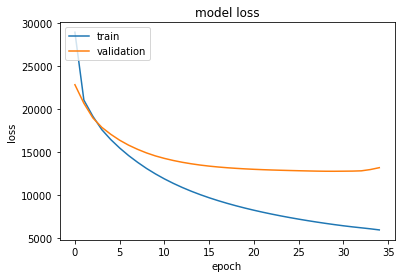

In [4]:
#This harcoded combination of hyper params should give the best SNR(around 10-11)
max_len = 195
batch_size = 200
n_lstm_units = 10
learning_rate = 0.001
dropout = 0

tl = train_lstm(batch_size=batch_size,
                dropout=dropout,
                n_lstm_layers=1,
                n_lstm_units=n_lstm_units,
                input_dm=513,
                output_dm=513,
                max_len=max_len,
                saved_model=None)
tl.train(max_epochs=200,
         verbose=True,
         learning_rate=learning_rate,
         model_op=None)
tl.plot_loss()

In [5]:
def output_cleaned_sound(model,tr_v_te,n_signals,max_len):
  """
  Outputs cleaned signal for each noisy signal present in the folder specified and based on the trained model provided in input
  The output is generate in the same folder as input
  Arguments - 
  tr_v_te: which is among{tr,v,te} indicating which folder to load files from
  model: trained pytorch model
  n_signals: Number of signals to generate output for (ideally this would be all the files in the folder ie 400 for test folder but that often exceeds RAM)


  """
  nos = np.arange(0,n_signals).astype(np.str)
  X_complex = np.zeros((n_signals,513,max_len)).astype(np.complex64)
  seq_lengths = np.zeros((n_signals))
  signals = []
  for i in range(0,n_signals):
      no = str(i)
      x_filename = "/".join([tr_v_te,tr_v_te]) +"x" + no.zfill(4) + ".wav"
      x, sr=librosa.load(x_filename, sr=None)
      signals.append(x)
      x_complex = stft(x, n_fft=1024, hop_length=512)
      l = int(x_complex.shape[1])
      seq_lengths[i]=max(l,max_len)
      X_complex[i,:,0:l] = x_complex


  X_mag = np.abs(X_complex)
  X_cap = np.nan_to_num(np.divide(X_complex,X_mag))

  X_inp = torch.tensor(X_mag).reshape(n_signals,max_len,513).to(device)
  X_len = torch.tensor(seq_lengths,dtype=torch.int64)
  sort_ind = torch.flip(torch.argsort(X_len),dims=[0])
  X_len = X_len[sort_ind]
  X_inp = X_inp[sort_ind]
  signals = [signals[j] for j in sort_ind]

  
  M_hat = F.sigmoid(model.forward(X_inp,X_len)).gt(0.5).int()

  seq_lengths = X_len.numpy()
  S_mag_pred = torch.mul(X_inp,M_hat).reshape(n_signals,513,max_len).detach().cpu().numpy()
  S_complex_pred = np.multiply(S_mag_pred,X_cap)
  for i in range(0,n_signals):
      no = str(i)
      op_filename = "/".join([tr_v_te,tr_v_te]) + "s_predicted" + no.zfill(4) + ".wav"
      s_complex_pred = S_complex_pred[i,:,0:seq_lengths[i]]
      s_pred = istft(s_complex_pred, hop_length=512, length = len(signals[i]))
      librosa.output.write_wav(op_filename,s_pred, sr)
      if((i+1)%100==0):
        print("Saved "+str(i)+ " cleaned sound files in the format:"+op_filename)


output_cleaned_sound(tl.trained_model,"te",400,max_len)

Saved 400 cleaned sound files in the format:te/tes_predicted0099.wav
Saved 400 cleaned sound files in the format:te/tes_predicted0199.wav
Saved 400 cleaned sound files in the format:te/tes_predicted0299.wav
Saved 400 cleaned sound files in the format:te/tes_predicted0399.wav
